# Example notebook for dithering

This notebook demostrates the dithering process for a given source.
The script will probably be moved to a python project (out of the notebook) later.

In [1]:
%pylab inline

# general packages
import os

import astropy.units as u
import astropy.table

# specsim (DESI related packages)
import specsim
import specsim.quickspecsim as qspecsim
import specsim.instrument as inst
import specsim.source as src
import specsim.config as conf
import specsim.fiberloss as floss
import specsim.observation as obs
import specsim.simulator as sim
import specsim.atmosphere as atm

mpl.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create a simulator object using the given configuration
desi = sim.Simulator('./config/desi-blur.yaml')

/Users/sybenzvi/anaconda/envs/desi2/lib/python2.7/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [3]:
# function to generate the wavelength values
def create_wlen_grid(num_wlen=10, desi=desi):
    wavelength = desi.simulated['wavelength']
    wlen_unit = wavelength.unit
    return np.linspace(wavelength.data[0], wavelength.data[-1], num_wlen) * wlen_unit

# function to generate a single source
def generate_source(disk_fraction=0., bulge_fraction=0., vary='', seed=23, minormajor=[1,1]):
    gen = np.random.RandomState(seed)
    varied = vary.split(',')
    source_fraction = np.tile([disk_fraction, bulge_fraction], (1, 1))
    source_half_light_radius = np.tile([0.45, 1.0], (1, 1))
    source_minor_major_axis_ratio = np.tile(minormajor, (1, 1))
    if 'pa' in varied:
        source_position_angle = 360. * gen.uniform(size=(1, 2))
    else:
        source_position_angle = np.tile([0., 0.], (1, 1))
    return source_fraction, source_half_light_radius, source_minor_major_axis_ratio, source_position_angle

# function to create the object with galsim parameters
def calculateFiberLoss(wlen_grid, fiber_placement, desi=desi):
    calc = floss.GalsimFiberlossCalculator(desi.instrument.fiber_diameter.to(u.um).value,
                                           wlen_grid.to(u.Angstrom).value,
                                           num_pixels=32, oversampling=32, moffat_beta=3.5,
                                           fiber_placement=fiber_placement)
    return calc

def get_desimodel_fiberloss(obj_type='lrg'):
    path = os.path.join(os.environ['DESIMODEL'], 'data', 'throughput',
                        'fiberloss-{0}.dat'.format(obj_type))
    t = astropy.table.Table.read(path, format='ascii', names=['wlen', 'accept'])
    return t

def get_fiberloss(source_fraction, source_half_light_radius, source_minor_major_axis_ratio,
                  source_position_angle, x, y, calc, seeing=1.1*u.arcsec, desi=desi,
                  output='test_dither_fiberloss.fits'):
    # Subtract instrumental PSF.
    Jacoby = 0.219
    seeing = 2.35482 * np.sqrt((seeing.to(u.arcsec).value/2.35482) ** 2 - Jacoby**2) * u.arcsec
    # Tabulate seeing.
    desi.atmosphere.seeing_fwhm_ref = seeing
    seeing_fwhm = desi.atmosphere.get_seeing_fwhm(wlen_grid).to(u.arcsec).value
    # Calculate optics.
    scale, blur, offset = desi.instrument.get_focal_plane_optics(x, y, wlen_grid)
    # Do the fiberloss calculations.
    return calc.calculate(
        seeing_fwhm,
        scale.to(u.um / u.arcsec).value, offset.to(u.um).value,
        blur.to(u.um).value,
        source_fraction, source_half_light_radius,
        source_minor_major_axis_ratio, source_position_angle,
        saved_images_file=output)

def generate_fiber_positions(nfiber=5000, seed=123, desi=desi):
    gen = np.random.RandomState(seed)
    focal_r = (
        np.sqrt(gen.uniform(size=nfiber)) * desi.instrument.field_radius)
    phi = 2 * np.pi * gen.uniform(size=nfiber)
    return np.cos(phi) * focal_r, np.sin(phi) * focal_r

In [4]:
# some constants
num_pixels = 32
oversampling = 32
wlen_grid = create_wlen_grid()
focal_x, focal_y = generate_fiber_positions(1)
source = generate_source()

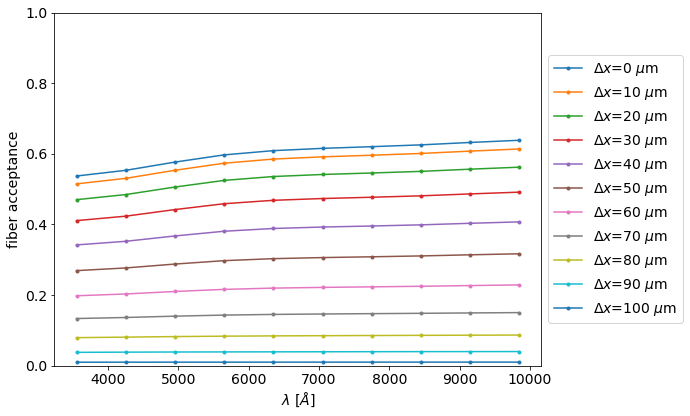

In [5]:
# first put the fiber in the middle with no dithering
fig, ax = plt.subplots(1,1, figsize=(8,6))

for dx in range(0,110,10):
    output = 'test_dither_fiberloss_{:03d}um.fits'.format(dx)
    GalsimCalculator = calculateFiberLoss(wlen_grid, [dx, 0], desi)
    fiber_loss = get_fiberloss(*source, x=focal_x, y=focal_y, calc=GalsimCalculator, desi=desi, output=output)
    ax.plot(wlen_grid, fiber_loss.flatten(), '.-',
            label="$\Delta x$={:g} $\mu$m".format(dx))
    
ax.set(xlabel=r'$\lambda$ [$\AA$]', ylabel='fiber acceptance', ylim=[0,1])
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

fig.tight_layout();